# testing overlap between ATAC-QTL and allelic imbalance from ATAC and loopQTL and allelic imbalance from loops

In [1]:
import pandas as pd
import numpy as np
from multiprocessing import Pool
from functools import partial
import glob
import os
import plotly.express as px
import math
import matplotlib.pyplot as plt
from matplotlib import colors
import pybedtools as pbed
from scipy import stats, special
from statsmodels.stats import multitest
import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.io as pio
import seaborn as sns

from functools import reduce
plt.rcParams['svg.fonttype'] = 'none'

base_dir = "http://bartzabel.ls.manchester.ac.uk/orozcolab/SNP2Mechanism/"


## start with ATAC-seq

In [4]:
all_SNPs_all = pd.read_csv("../ATAC_allelic_imbalance/.local/results/ATAC_ALL_allelic_imbalance_with_betabinom.csv.gz", index_col = 0)

In [3]:
ATAC_nominal_CD4 = pd.read_csv(f"{base_dir}/QTLs/ATAC/ATAC_nominal_CD4_merged.txt", sep = " ")
ATAC_nominal_CD8 = pd.read_csv(f"{base_dir}/QTLs/ATAC/ATAC_nominal_CD8_merged.txt", sep = " ")

In [5]:
# we are only interested in the variants/peak pairs that directly overlap
ATAC_nominal_CD4 = ATAC_nominal_CD4[abs(ATAC_nominal_CD4["dist_phe_var"]) < 1]
ATAC_nominal_CD8 = ATAC_nominal_CD8[abs(ATAC_nominal_CD8["dist_phe_var"]) < 1]
all_SNPs_all = all_SNPs_all[(all_SNPs_all["ID"] != ".")]

In [6]:
# print sizes of the resulting datasets
print(len(ATAC_nominal_CD8))
print(len(ATAC_nominal_CD4))
print(len(all_SNPs_all))

21081
18313
243664


In [7]:
# print number of significant caQTL for variants that overlap their peak
print(len(ATAC_nominal_CD8[ATAC_nominal_CD8["nom_pval"] < 0.0001].drop_duplicates("var_id")))
print(len(ATAC_nominal_CD4[ATAC_nominal_CD4["nom_pval"] < 0.0001].drop_duplicates("var_id")))

10471
8514


In [8]:
# merge the two lists based on var_id. we can't use peak id because the allelic imbalance calling doesn't depend on actual peaks called
merged_CD4 = all_SNPs_all.merge(ATAC_nominal_CD4, left_on = "ID", right_on = "var_id", how = "inner")
merged_CD8 = all_SNPs_all.merge(ATAC_nominal_CD8, left_on = "ID", right_on = "var_id", how = "inner")

In [9]:
print(len(merged_CD8))
print(len(merged_CD4))

13726
11813


In [13]:
# calculate the proportion of snps that have significant allelic imbalance and are also significant QTLs
sig_both = merged_CD8[(merged_CD8["svalues_betabinom"] < 0.1)]
sig_both = sig_both[sig_both["nom_pval"] < 0.0001]
print(len(sig_both))

3363


In [14]:
# normalize the ratio to be somewhat comparable with the slope. the ratio column is just the ratio between reads from ALT and reads from REF.
sig_both["ratio"] = sig_both["ratio"].apply(lambda x: -1/x if x < 1 else x)

<Axes: xlabel='ratio', ylabel='slope'>

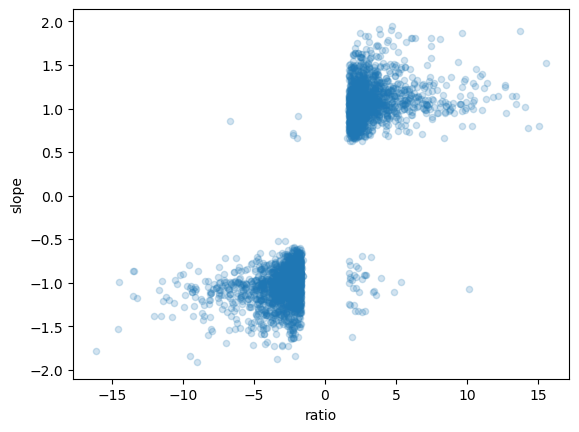

In [15]:
sig_both.plot(x = "ratio", y = "slope", kind = "scatter", alpha = 0.2)

In [16]:
# Create concordant mask (both positive or both negative)
concordant_mask = np.sign(sig_both['ratio']) == np.sign(sig_both['slope'])

# Create discordant mask (one positive, one negative)
discordant_mask = np.sign(sig_both['ratio']) != np.sign(sig_both['slope'])

# Count concordant and discordant rows
num_concordant = concordant_mask.sum()
num_discordant = discordant_mask.sum()

print(f"Number of concordant rows: {num_concordant}")
print(f"Number of discordant rows: {num_discordant}")
print(f"ratio: {num_concordant/(num_discordant + num_concordant)}")

Number of concordant rows: 3323
Number of discordant rows: 40
ratio: 0.9881058578650015


In [17]:
# do the same thing for CD4
sig_both = merged_CD4[(merged_CD4["corrected_p_val_greater"] < 0.1) | (merged_CD4["corrected_p_val_less"] < 0.1)]
sig_both = sig_both[sig_both["nom_pval"] < 0.0001]
sig_both["ratio"] = sig_both["ratio"].apply(lambda x: -1/x if x < 1 else x)
print(len(sig_both))
# Create concordant mask (both positive or both negative)
concordant_mask = np.sign(sig_both['ratio']) == np.sign(sig_both['slope'])

# Create discordant mask (one positive, one negative)
discordant_mask = np.sign(sig_both['ratio']) != np.sign(sig_both['slope'])

# Count concordant and discordant rows
num_concordant = concordant_mask.sum()
num_discordant = discordant_mask.sum()

print(f"Number of concordant rows: {num_concordant}")
print(f"Number of discordant rows: {num_discordant}")
print(f"ratio: {num_concordant/(num_discordant + num_concordant)}")

4243
Number of concordant rows: 4151
Number of discordant rows: 92
ratio: 0.978317228376149


## loop QTLs overlaps with loop allelic imbalance
we find that the overlap between the two datasets is quite low. We do see 100% concordance for the hits we have

In [22]:
output_dataframe_CD4 = pd.read_csv("../HiC_allelic_imbalance/.local/results/allelic_imbalance_CD4_apeglm_results.csv", index_col=0)
output_dataframe_CD8 = pd.read_csv("../HiC_allelic_imbalance/.local/results/allelic_imbalance_CD8_apeglm_results.csv", index_col=0)
output_dataframe_ALL = pd.read_csv("../HiC_allelic_imbalance/.local/results/allelic_imbalance_ALL_apeglm_results.csv", index_col=0)

output_dataframe_CD8["ratio"] = output_dataframe_CD8["ALT_counts"]/output_dataframe_CD8["REF_counts"]
output_dataframe_CD4["ratio"] = output_dataframe_CD4["ALT_counts"]/output_dataframe_CD4["REF_counts"]
output_dataframe_ALL["ratio"] = output_dataframe_ALL["ALT_counts"]/output_dataframe_ALL["REF_counts"]

In [23]:
loop_nominal_CD4 = pd.read_csv(f"{base_dir}/QTLs/HiC/loop_nominal_CD4_merged.txt", sep = " ")
loop_nominal_CD8 = pd.read_csv(f"{base_dir}/QTLs/HiC/loop_nominal_CD8_merged.txt", sep = " ")

In [ ]:
def if_overlap(row):
    if row["var_from"] > (row["phe_from"]) and row["var_from"] < (row["phe_from"] + 5000):
        return True
    if row["var_from"] > (row["phe_to"] - 5000) and row["var_from"] < (row["phe_to"]):
        return True
    return False
loop_nominal_CD8["overlap_anchor"] = loop_nominal_CD8.apply(if_overlap, axis = 1)
loop_nominal_CD4["overlap_anchor"] = loop_nominal_CD4.apply(if_overlap, axis = 1)

In [ ]:
# we find that only 5% of the loopQTLs actually have the variant overlapping the loop anchors. compared to 50% with caQTL
loop_nominal_CD8[(loop_nominal_CD8["overlap_anchor"] == True) & (loop_nominal_CD8["nom_pval"] < 0.0001)].drop_duplicates("phe_id")

,phe_id,phe_chr,phe_from,phe_to,phe_strd,n_var_in_cis,dist_phe_var,var_id,var_chr,var_from,var_to,nom_pval,r_squared,slope,best_hit,overlap_anchor
11983,89981,chr18,10607501,12227500,+,10147,0,rs501992,chr18,10608912,10608912,8.039820e-07,0.382409,0.646908,0,True
12708,89982,chr18,10620001,12217500,+,10092,0,rs2851905,chr18,12212623,12212623,6.692520e-05,0.269972,0.798912,0,True
13218,89983,chr18,10645001,12177500,+,9913,0,rs4462671,chr18,12172513,12172513,8.870440e-06,0.323454,-0.996735,0,True
38146,90541,chr18,31552501,31975000,+,4627,0,rs78617427,chr18,31553987,31553987,2.536960e-05,0.296088,1.195650,1,True
120337,91882,chr19,6515001,7005000,+,6628,0,rs11669654,chr19,7000999,7000999,3.647660e-05,0.286407,-0.720750,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6352657,89350,chr17,75112501,75415000,+,4715,0,rs9908820,chr17,75412738,75412738,3.188010e-07,0.403828,-0.924410,0,True
6353006,89351,chr17,75237501,75415000,+,4449,0,rs9908820,chr17,75412738,75412738,1.549890e-06,0.366779,-0.880985,0,True
6353441,89361,chr17,75290001,75590000,+,4746,0,rs62089222,chr17,75589597,75589597,7.841510e-05,0.265629,1.250300,1,True
6354067,89368,chr17,75425001,75592500,+,4426,0,rs62089216,chr17,75587596,75587596,1.756810e-05,0.305767,1.292440,0,True


In [26]:
merged_CD4 = output_dataframe_CD4.merge(loop_nominal_CD4, left_on = ["rsID", "loopID"], right_on = ["var_id","phe_id"], how = "inner")
merged_CD8 = output_dataframe_CD8.merge(loop_nominal_CD8, left_on = ["rsID", "loopID"], right_on = ["var_id","phe_id"], how = "inner")

In [27]:
merged_CD4["ratio"] = merged_CD4["ratio"].apply(lambda x: -1/x if x < 1 else x)
merged_CD8["ratio"] = merged_CD8["ratio"].apply(lambda x: -1/x if x < 1 else x)

In [28]:
print(len(merged_CD8.drop_duplicates("loopID")))
print(len(merged_CD4.drop_duplicates("loopID")))

22
16


In [29]:
sig_both = merged_CD8[merged_CD8["nom_pval"] < 0.0001]
print(len(sig_both.drop_duplicates("loopID")))

14


<Axes: xlabel='ratio', ylabel='slope'>

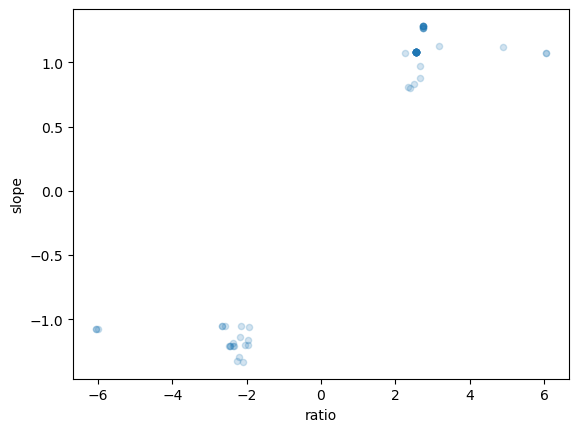

In [30]:
sig_both.plot(x = "ratio", y = "slope", kind = "scatter", alpha = 0.2)

In [31]:
# Create concordant mask (both positive or both negative)
concordant_mask = np.sign(sig_both['ratio']) == np.sign(sig_both['slope'])

# Create discordant mask (one positive, one negative)
discordant_mask = np.sign(sig_both['ratio']) != np.sign(sig_both['slope'])

# Count concordant and discordant rows
num_concordant = concordant_mask.sum()
num_discordant = discordant_mask.sum()

print(f"Number of concordant rows: {num_concordant}")
print(f"Number of discordant rows: {num_discordant}")
print(f"ratio: {num_concordant/(num_discordant + num_concordant)}")

Number of concordant rows: 73
Number of discordant rows: 0
ratio: 1.0


In [32]:
sig_both = merged_CD4[merged_CD4["nom_pval"] < 0.0001]
print(len(sig_both.drop_duplicates("loopID")))
# Create concordant mask (both positive or both negative)
concordant_mask = np.sign(sig_both['ratio']) == np.sign(sig_both['slope'])

# Create discordant mask (one positive, one negative)
discordant_mask = np.sign(sig_both['ratio']) != np.sign(sig_both['slope'])

# Count concordant and discordant rows
num_concordant = concordant_mask.sum()
num_discordant = discordant_mask.sum()

print(f"Number of concordant rows: {num_concordant}")
print(f"Number of discordant rows: {num_discordant}")
print(f"ratio: {num_concordant/(num_discordant + num_concordant)}")

14
Number of concordant rows: 79
Number of discordant rows: 0
ratio: 1.0
